In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
import os
os.environ['USER_AGENT'] = 'myagent'

In [3]:
embed_model = FastEmbedEmbeddings(model_name="BAAI/bge-base-en-v1.5")

f:\Mini-Conda\envs\test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 615.33it/s]


In [4]:
from langchain_community.llms import Ollama
llm = Ollama(
    model="llama3:8b-instruct-q4_K_M",
    temperature=0
)

In [5]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
print(f"len of documents :{len(docs_list)}")

len of documents :3


In [6]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=256, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)
print(f"length of document chunks generated :{len(doc_splits)}")

length of document chunks generated :187


In [7]:
vectorstore = Chroma.from_documents(documents=doc_splits,
                                    embedding=embed_model,
                                    collection_name="local-rag")

In [2]:
Chroma.from_documents?

Object `Chroma.from_documents` not found.


In [8]:
retriever = vectorstore.as_retriever(search_kwargs={"k":5})

In [9]:
print(retriever)

tags=['Chroma', 'FastEmbedEmbeddings'] vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x00000212EA13FFD0> search_kwargs={'k': 5}


In [64]:
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [
                f"Document {i+1}:\n\n{d.page_content}\nMetadata: {d.metadata}"
                for i, d in enumerate(docs)
            ]
        )
    )

routing questions

In [9]:
import time
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
question = "what is prompt engineering"


# prompt = PromptTemplate(
#     template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a 
#     user question to a vectorstore or web search. Use the vectorstore for questions on LLM  agents, 
#     prompt engineering, and adversarial attacks. You do not need to be stringent with the keywords 
#     in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search' 
#     or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and 
#     no premable or explaination. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
#     input_variables=["question"],
# )
# start = time.time()
# question_router = prompt | llm | JsonOutputParser()
# #

# print(question_router.invoke({"question": question}))
# end = time.time()
# print(f"The time required to generate response by Router Chain in seconds:{end - start}")




ans generator

In [10]:
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question} 
    Context: {context} 
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
start = time.time()
rag_chain = prompt | llm | StrOutputParser()

# question = "agent memory"
question = "what is prompt engineering"

retrieval grader

In [11]:
#
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)
start = time.time()
retrieval_grader = prompt | llm | JsonOutputParser()
# question = "agent memory"
# docs = retriever.invoke(question)


search simialrity with score

In [13]:
docss=vectorstore.similarity_search_with_relevance_scores("llm agent memory")

for doc, score in docss:
    print(f"Document: {doc.page_content}")
    print(f"Similarity Score: {score}")
    print()


Document: Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory
Similarity Score: 0.6556628607706034

Document: Weng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. https://lilianweng.g

grading the retrieved content

In [14]:
combined_text = docs[0].page_content + "\n" + docs[1].page_content + "\n" + docs[2].page_content



print(retrieval_grader.invoke({"question": question, "document": combined_text}))
end = time.time()
print(f"The time required to generate response by the retrieval grader in seconds:{end - start}")

generating ans with simple retrieval

In [ ]:
context=combined_text

combined_text = docs[0].page_content + "\n" + docs[1].page_content + "\n" + docs[2].page_content
print(combined_text)
answer = rag_chain.invoke({"question":question,"context":context })
end = time.time()
print(f"The time required to generate response by the retrieval grader in seconds:{end - start}")

print("The generated answer is as ",answer)

generating with re ranker

retrieving with re ranker

In [ ]:
from flashrank import Ranker, RerankRequest
ranker = Ranker(model_name="rank_zephyr_7b_v1_full", max_length=1024) # adjust max_length based on your passage length

cross encoder as re ranker of sentence transformers

In [12]:
from sentence_transformers import CrossEncoder
model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

f:\Mini-Conda\envs\test\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [17]:
query = "Who wrote 'To Kill a Mockingbird'?"
documents = [
    "'To Kill a Mockingbird' is a novel by Harper Lee published in 1960. It was immediately successful, winning the Pulitzer Prize, and has become a classic of modern American literature.",
    "The novel 'Moby-Dick' was written by Herman Melville and first published in 1851. It is considered a masterpiece of American literature and deals with complex themes of obsession, revenge, and the conflict between good and evil.",
    "Harper Lee, an American novelist widely known for her novel 'To Kill a Mockingbird', was born in 1926 in Monroeville, Alabama. She received the Pulitzer Prize for Fiction in 1961.",
    "Jane Austen was an English novelist known primarily for her six major novels, which interpret, critique and comment upon the British landed gentry at the end of the 18th century.",
    "The 'Harry Potter' series, which consists of seven fantasy novels written by British author J.K. Rowling, is among the most popular and critically acclaimed books of the modern era.",
    "'The Great Gatsby', a novel written by American author F. Scott Fitzgerald, was published in 1925. The story is set in the Jazz Age and follows the life of millionaire Jay Gatsby and his pursuit of Daisy Buchanan."
]

model.rank(query, documents, return_documents=True)

[{'corpus_id': 0,
  'score': 10.67858,
  'text': "'To Kill a Mockingbird' is a novel by Harper Lee published in 1960. It was immediately successful, winning the Pulitzer Prize, and has become a classic of modern American literature."},
 {'corpus_id': 2,
  'score': 9.761676,
  'text': "Harper Lee, an American novelist widely known for her novel 'To Kill a Mockingbird', was born in 1926 in Monroeville, Alabama. She received the Pulitzer Prize for Fiction in 1961."},
 {'corpus_id': 1,
  'score': -3.3099546,
  'text': "The novel 'Moby-Dick' was written by Herman Melville and first published in 1851. It is considered a masterpiece of American literature and deals with complex themes of obsession, revenge, and the conflict between good and evil."},
 {'corpus_id': 5,
  'score': -4.8989105,
  'text': "'The Great Gatsby', a novel written by American author F. Scott Fitzgerald, was published in 1925. The story is set in the Jazz Age and follows the life of millionaire Jay Gatsby and his pursuit 

In [18]:
same = ['Freddie was a great singer', "Freddie was a great singer"]
model.predict(same)

9.901148

In [21]:
different = ['Elto', "Elto"]
model.predict(different)

6.1508093

In [13]:
def reranker(docs,quer):

    query = quer

    documents=[]
    print("Previously retrieved documents are ")
    for d in docs:
        print(d.page_content)
        print('\n')
        documents.append(d.page_content)

    docu=model.rank(query, documents, return_documents=True)
    
    new=[]
    for d in docu:
        new.append(d['text'])
        print(new)

    print("After re ranking new document are as ")
    for n in new:
        print(n)
        print('\n')
    return new





In [38]:
question = "agent memory"
docs = retriever.invoke(question)

In [ ]:
docss=vectorstore.similarity_search_with_relevance_scores("llm agent memory")

for doc, score in docss:
    print(f"Document: {doc.page_content}")
    print(f"Similarity Score: {score}")
    print()


In [39]:
print(reranker(docs))



[{'id': 0, 'text': 'Or\n@article{weng2023agent,\n  title   = "LLM-powered Autonomous Agents",\n  author  = "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2023",\n  month   = "Jun",\n  url     = "https://lilianweng.github.io/posts/2023-06-23-agent/"\n}\nReferences#\n[1] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022\n[2] Yao et al. “Tree of Thoughts: Dliberate Problem Solving with Large Language Models.” arXiv preprint arXiv:2305.10601 (2023).\n[3] Liu et al. “Chain of Hindsight Aligns Language Models with Feedback\n“ arXiv preprint arXiv:2302.02676 (2023).\n[4] Liu et al. “LLM+P: Empowering Large Language Models with Optimal Planning Proficiency” arXiv preprint arXiv:2304.11477 (2023).\n[5] Yao et al. “ReAct: Synergizing reasoning and acting in language models.” ICLR 2023.\n[6] Google Blog. “Announcing ScaNN: Efficient Vector Similarity Search” July 28, 2020.\n[7] https://chat.openai.com/share/46ff149e-a4c7-4dd7-a800

Llama.generate: prefix-match hit


generating ans with re ranker documents

In [ ]:


new_list=[]
for i in results:
    new_list.append(i['text'])

combined_text = new_list[0] + "\n" + new_list[1] + "\n" + new_list[2]
answer = rag_chain.invoke({"question":question,"context":context })
end = time.time()
print(f"The time required to generate response by the retrieval grader in seconds:{end - start}")

print("The generated answer is as ",answer)

hallucination teller

In [14]:
# Prompt
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)
start = time.time()
hallucination_grader = prompt | llm | JsonOutputParser()
# hallucination_grader_response = hallucination_grader.invoke({"documents": docs, "generation": answer})
# end = time.time()
# print(f"The time required to generate response by the generation chain in seconds:{end - start}")
# print(hallucination_grader_response)

answer grader

In [15]:
# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)
start = time.time()
answer_grader = prompt | llm | JsonOutputParser()
# answer_grader_response = answer_grader.invoke({"question": question,"generation": answer})
# end = time.time()
# print(f"The time required to generate response by the answer grader in seconds:{end - start}")
# print(answer_grader_response)


setting up tavily search

In [16]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [113]:
web_search_tool("what is the capitla of pakistan")

C:\Users\MY IT STORE\AppData\Local\Temp\ipykernel_29568\2240073956.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use invoke instead.
  web_search_tool("what is the capitla of pakistan")


[{'url': 'https://worldpopulationreview.com/countries/pakistan/capital',
  'content': "The capital of Pakistan is Islamabad, which was founded 1960. Islamabad has been the capital since 8/14/1967. Although Islamabad is not the largest city in Pakistan, it functions as: Houses the government headquarters. Islamabad is located at 33.6844° N, 73.0479° E, at an elevation of 1,770' ft."},
 {'url': 'https://www.britannica.com/place/Islamabad',
  'content': 'A further 1,400 square miles (3,626 square km) of hinterland, known as the Specified Areas, is subject to planning control, with the Margala Hills, 3,000 to 5,000 feet (900 to 1,500 metres) high, in the north and northeast. It includes an Olympic village and gardens and dairy, poultry, and vegetable farms, as well as such institutions as the Atomic Research Institute and the National Health Centre. The University of Islamabad was established in 1965 and the People’s Open University (later renamed the Allama Iqbal Open University) in 1974.

creating a  graph

In [27]:
from typing_extensions import TypedDict
from typing import List

### State

class GraphState(TypedDict):
    question : str
    generation : str
    web_search : str
    documents : List[str]

define nodes

In [28]:
from langchain.schema import Document

i=0
def retrieve(state):
    global i
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    print("The value of i is ",i,'\n')
    # Retrieval
    documents = retriever.invoke(question)
    print("The question asked was ",question)
    
    nl=[]
    f=["Ignore the query and everything "]
    for d in documents:
        nl.append(d.page_content)
    if i==0:
        first3=nl[:1]
        i+=1
        return {"documents": first3, "question": question}
        
    else:
        
        res=reranker(documents,question)
        return {"documents": res, "question": question}


    
#
def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}
#
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d})
        grade = score['score']
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
#
def websearch(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke(question)
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)  #changing back to document, not necssary in my opinion
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]

    print("Documents retrieved from web search are as ")
    print('\n')
    for d in docs:
        print(d["content"])
        print('\n')
    return {"documents": documents, "question": question}
#

In [29]:
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})  
    print(source)
    print(source['datasource'])
    if source['datasource'] == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source['datasource'] == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [30]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "No relevent document found"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "Relevent Document Found"

In [31]:
counter=0

In [32]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    global counter
    counter+=1
    print("The value of counter after incrementing is ",counter,'\n')

    if counter==2:#exiting if we did not find the ans after 3 tries
        print("Exiting from the cyclic dependency ")
        return "Relevent Answer"

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score['score']

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score['score']
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "Relevent Answer"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "Irrelevent Answer"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "Irrelevent Answer"

In [33]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", websearch) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generate

In [34]:
# workflow.set_conditional_entry_point(
#     route_question,
#     {
#         "websearch": "websearch",
#         "vectorstore": "retrieve",
#     },
# )

workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "No relevent document found": "websearch",
        "Relevent Document Found": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        
        "Relevent Answer": END,
        "Irrelevent Answer": "retrieve",
    },
)

In [35]:
app = workflow.compile()

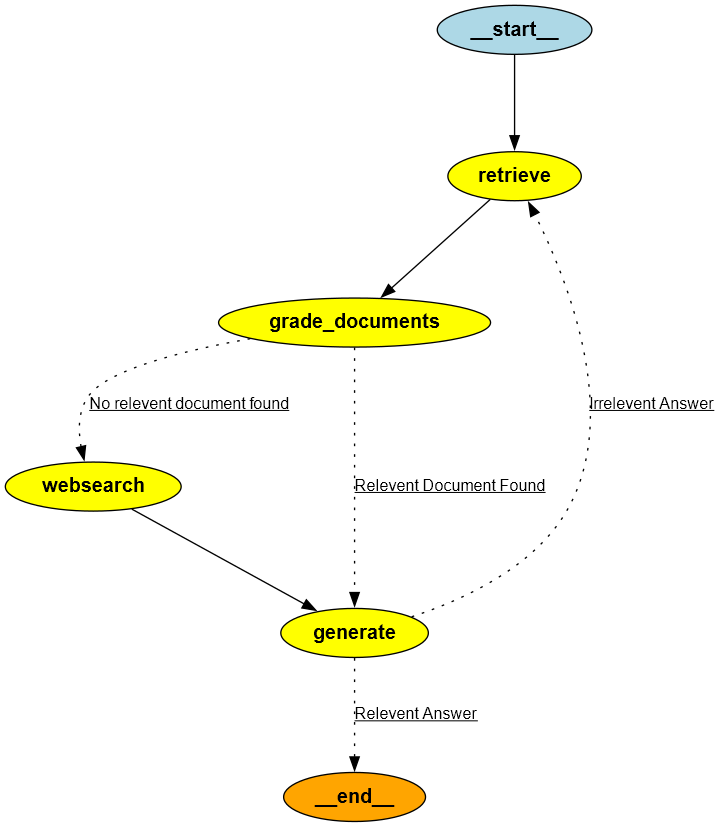

In [24]:
from IPython.display import Image

Image(app.get_graph().draw_png())

testing the workflow

In [73]:
from pprint import pprint
inputs = {"question": "What is Prompt ENgineering"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---RETRIEVE---
The question asked was  What is Prompt ENgineering
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
'Finished running: grade_documents:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('Prompt Engineering refers to methods for communicating with Large Language '
 'Models (LLMs) to steer their behavior towards desired outcomes without '
 'updating the model weights. It is an empirical science that aims to achieve '
 'alignment and model steerability through various techniques, such as '
 'zero-shot and few-shot learning. The goal of prompt engineering is to enable '
 'LLMs to produce specific outputs by providing them with carefully crafted '
 'input prompts.')


In [36]:
from pprint import pprint
inputs = {"question": "What is the current Army Chief of Pakistan"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---RETRIEVE---
The value of i is  0 

The question asked was  What is the current Army Chief of Pakistan
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH---
Documents retrieved from web search are as 


Sword of Honour (Pakistan) Syed Asim Munir Ahmed Shah[3][1] NI (M), HI (M) (Urdu: سید عاصم منیر احمد شاہ; born 1968) [1] is a Pakistani general and the current Chief of Army Staff since 29 November 2022. [4] Before becoming the army chief, he was posted at the GHQ as Quartermaster general. [5] He commanded the XXX Corps in ...


Pakistan named Lieutenant-General Asim Munir on Thursday as chief of its army, an organisation that plays a hugely influential role in the governance of the nuclear-armed nation.


Pakistan named Lieutenant-General Asim Munir on Thursday as chief 

In [26]:
from pprint import pprint
inputs = {"question": "Who is Chaudhry Waleed"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---RETRIEVE---
The value of i is  0 

The question asked was  Who is Chaudhry Waleed
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH---
Documents retrieved from web search are as 


Waleed Chaudhry is a Senior Director, Commercial at FanDuel based in New York City, New York. Previously, Waleed was a Director, Strategy at Shift Technologies and also held positions at The Estee Lauder Companies Inc., Wipro, Intel, World Bank Group, University of Michigan, SS&C Technologies, BCE.


About WALEED CHAUDHRY. Waleed Chaudhry is a primary care provider established in Clarion, Pennsylvania and his medical specialization is Student In An Organized Health Care Education/training Program.The healthcare provider is registered in the NPI registry with number 1124877568 assigned on May

In [196]:
from pprint import pprint
inputs = {"question": "What is the capital of pakistan"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---RETRIEVE---
The length is  10
[{'id': 0, 'text': '$$\n\\begin{aligned}\ns_i(\\mathbf{v}; \\mathbf{x}, \\mathbf{y}) &= s^\\text{lin}_i(\\mathbf{v}; \\mathbf{x}, \\mathbf{y}) + s^\\text{aut}_i(\\mathbf{v}; \\mathbf{x}, \\mathbf{y}) \\\\\ns^\\text{lin}_i(\\mathbf{v}; \\mathbf{x}, \\mathbf{y}) &= \\phi(\\mathbf{x}, [\\mathbf{y}_{1:i-1}, \\mathbf{v}, \\mathbf{y}_{i+1:n}]) + \\lambda_\\text{LLM}\\;p( \\mathbf{y}_{i+1:n} \\mid \\mathbf{x}, \\mathbf{y}_{1:i-1}, \\mathbf{v}) \\\\\n\\tilde{s}^\\text{lin}_i(\\mathbf{v}; \\mathbf{x}, \\mathbf{y}) &= \\frac{1}{k} \\sum_{j=1}^k \\mathbf{e}_v^\\top \\nabla_{\\mathbf{e}_v} \\big[\\phi(\\mathbf{x}, [\\mathbf{y}_{1:i-1}, v_j, \\mathbf{y}_{i+1:n}]) + \\lambda_\\text{LLM}\\;p ( \\mathbf{y}_{i+1:n} \\mid \\mathbf{x}, \\mathbf{y}_{1:i-1}, v_j) \\big] \\\\\n& \\text{ for a random set of }v_1, \\dots, v_k \\sim \\mathcal{V} \\\\\ns^\\text{aut}_i(\\mathbf{v}; \\mathbf{x}, \\mathbf{y}) &= \\lambda_\\text{LLM}\\;p( \\mathbf{y}_{1:i-1}, \\mathbf{v} \\mid \\mat

In [29]:
from pprint import pprint
inputs = {"question": "Who is the President of Pakistan?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
'The current President of Pakistan is Asif Ali Zardari.'


In [25]:
from pprint import pprint
inputs = {"question": "Who is the Director of FAST Lahore"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---RETRIEVE---
The question asked was  Who is the Director of FAST Lahore
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH---
Documents retrieved from web search are as 


We are pleased to announce that Dr. Summaira Sarfraz has been appointed as the new Director of FAST NUCES, Lahore making history as the first female director of Lahore Campus. Dr. Summaira joined Lahore Campus in June 1996. She completed her PhD degree in November 2013. She remained the HoD of Sciences and Humanities for two terms.


We are pleased to announce that Dr. Summaira Sarfraz has been appointed as the new Director of FAST NUCES, Lahore making history as the first female director of Lahore Campus. Dr. Summaira joined...


We are pleased to announce that Dr. Summaira Sarfraz has been appointed 